
=== IRIS: Mean, Median, Skewness (BEFORE) ===

          Feature     Mean  Median  Skewness Distribution
sepal length (cm) 5.843333    5.80  0.314911    Symmetric
 sepal width (cm) 3.057333    3.00  0.318966    Symmetric
petal length (cm) 3.758000    4.35 -0.274884    Symmetric
 petal width (cm) 1.199333    1.30 -0.102967    Symmetric


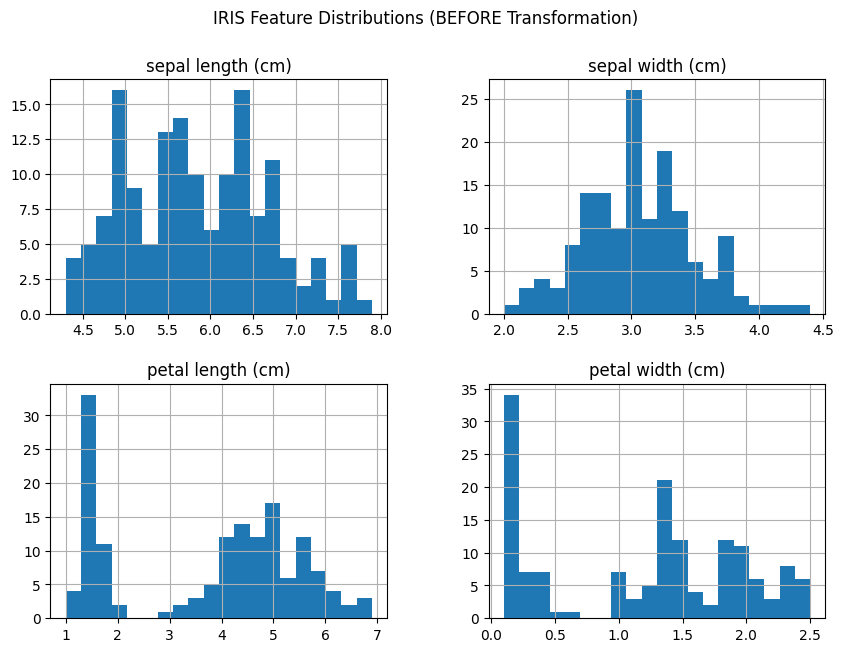

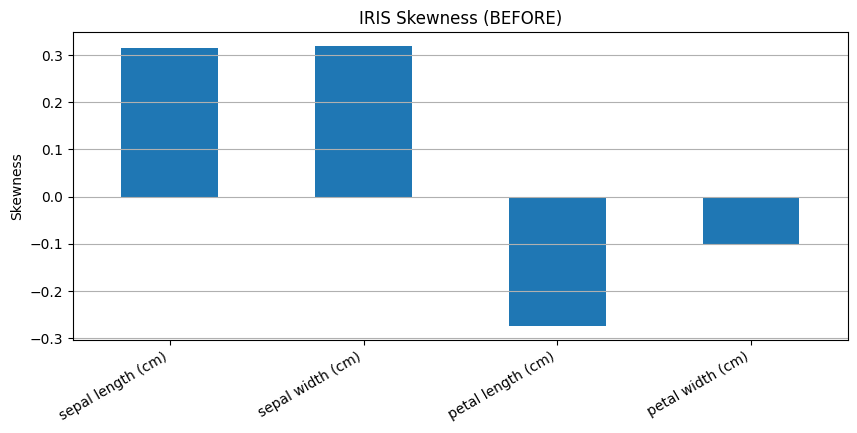


=== Transformations Chosen (only for asymmetric features) ===

sepal length (cm)         | Transform: None         | Skew: +0.3149  ->  +0.3149
sepal width (cm)          | Transform: None         | Skew: +0.3190  ->  +0.3190
petal length (cm)         | Transform: None         | Skew: -0.2749  ->  -0.2749
petal width (cm)          | Transform: None         | Skew: -0.1030  ->  -0.1030

=== IRIS: Mean, Median, Skewness (AFTER) ===

          Feature     Mean  Median  Skewness Distribution
sepal length (cm) 5.843333    5.80  0.314911    Symmetric
 sepal width (cm) 3.057333    3.00  0.318966    Symmetric
petal length (cm) 3.758000    4.35 -0.274884    Symmetric
 petal width (cm) 1.199333    1.30 -0.102967    Symmetric


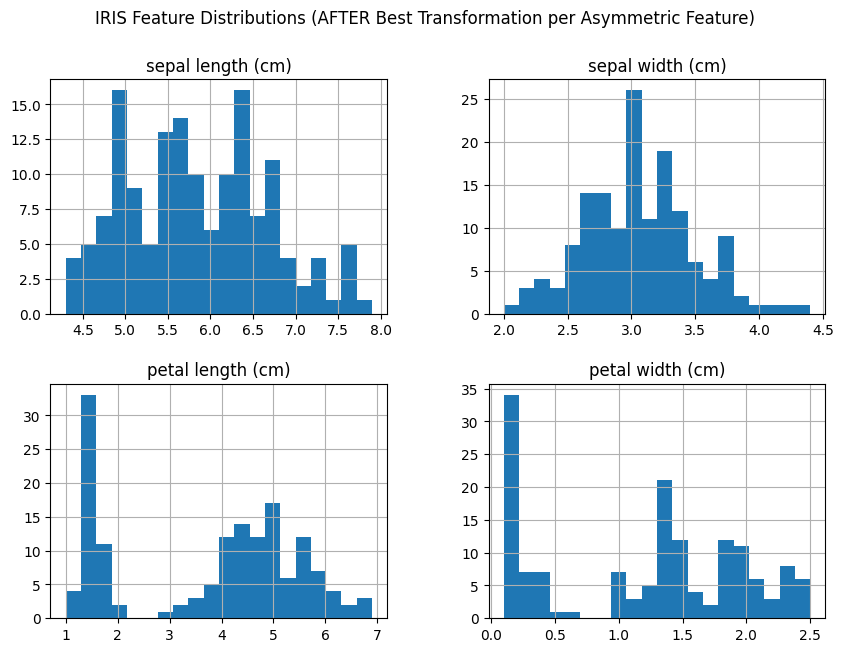

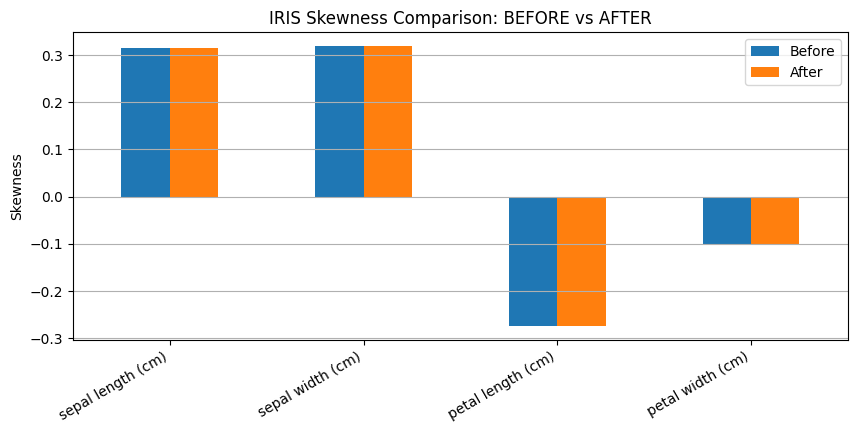

In [1]:
# ------------------------------------------------------------
# Programming Assignment 27
# Symmetry & Skewness Analysis – IRIS Dataset (Case Study)
# Compute Mean, Median, Skewness
# Classify: Symmetric / Right-Skewed / Left-Skewed
# Visualize: Histograms + Bar plots
# Fix asymmetry using: log / sqrt / Box-Cox / Yeo-Johnson
# (Chooses the BEST transform per asymmetric feature by minimizing |skewness|)
# ------------------------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.datasets import load_iris
from sklearn.preprocessing import PowerTransformer

# -----------------------------
# 1) Load Iris Dataset
# -----------------------------
iris = load_iris(as_frame=True)
df = iris.frame.copy()

# Keep only feature columns (exclude target)
feature_cols = iris.feature_names
X = df[feature_cols].copy()

# -----------------------------
# 2) Helper: classify skewness
# -----------------------------
def classify_skew(sk):
    if sk > 0.5:
        return "Right-Skewed"
    elif sk < -0.5:
        return "Left-Skewed"
    return "Symmetric"

# -----------------------------
# 3) Compute Mean, Median, Skewness + Classification
# -----------------------------
rows = []
for col in X.columns:
    mean_val = X[col].mean()
    median_val = X[col].median()
    sk_val = skew(X[col], bias=False)
    rows.append([col, mean_val, median_val, sk_val, classify_skew(sk_val)])

stats_before = pd.DataFrame(rows, columns=["Feature", "Mean", "Median", "Skewness", "Distribution"])
print("\n=== IRIS: Mean, Median, Skewness (BEFORE) ===\n")
print(stats_before.to_string(index=False))

# -----------------------------
# 4) Histograms BEFORE
# -----------------------------
X.hist(bins=20, figsize=(10, 7))
plt.suptitle("IRIS Feature Distributions (BEFORE Transformation)")
plt.show()

# -----------------------------
# 5) Bar Plot: Skewness BEFORE
# -----------------------------
sk_before = X.apply(lambda s: skew(s, bias=False))
sk_before.plot(kind="bar", figsize=(10, 4))
plt.title("IRIS Skewness (BEFORE)")
plt.ylabel("Skewness")
plt.xticks(rotation=30, ha="right")
plt.grid(axis="y")
plt.show()

# -----------------------------
# 6) Transformation Logic (only if asymmetric)
#    Try: log1p, sqrt, Box-Cox, Yeo-Johnson
#    Pick transformation with smallest |skewness|
# -----------------------------
def best_transform(series):
    s = series.values.astype(float)

    candidates = []

    # Original
    candidates.append(("None", s, skew(s, bias=False)))

    # log1p and sqrt require non-negative
    if np.min(s) >= 0:
        candidates.append(("log1p", np.log1p(s), skew(np.log1p(s), bias=False)))
        candidates.append(("sqrt", np.sqrt(s), skew(np.sqrt(s), bias=False)))

    # Box-Cox requires strictly positive
    if np.min(s) > 0:
        bc = PowerTransformer(method="box-cox", standardize=False)
        s_bc = bc.fit_transform(s.reshape(-1, 1)).ravel()
        candidates.append(("Box-Cox", s_bc, skew(s_bc, bias=False)))

    # Yeo-Johnson works for any real values
    yj = PowerTransformer(method="yeo-johnson", standardize=False)
    s_yj = yj.fit_transform(s.reshape(-1, 1)).ravel()
    candidates.append(("Yeo-Johnson", s_yj, skew(s_yj, bias=False)))

    # Choose candidate that minimizes absolute skewness
    best = min(candidates, key=lambda x: abs(x[2]))
    return best  # (name, transformed_values, new_skew)

transform_chosen = {}
X_fixed = X.copy()

for col in X.columns:
    sk_val = skew(X[col], bias=False)
    dist = classify_skew(sk_val)

    if dist == "Symmetric":
        transform_chosen[col] = ("None", sk_val, sk_val)
        continue

    name, new_vals, new_sk = best_transform(X[col])
    X_fixed[col] = new_vals
    transform_chosen[col] = (name, sk_val, new_sk)

# Print what was chosen per asymmetric feature
print("\n=== Transformations Chosen (only for asymmetric features) ===\n")
for col in X.columns:
    name, old_sk, new_sk = transform_chosen[col]
    print(f"{col:25s} | Transform: {name:12s} | Skew: {old_sk:+.4f}  ->  {new_sk:+.4f}")

# -----------------------------
# 7) Compute Mean, Median, Skewness AFTER + Classification
# -----------------------------
rows_after = []
for col in X_fixed.columns:
    mean_val = X_fixed[col].mean()
    median_val = np.median(X_fixed[col])
    sk_val = skew(X_fixed[col], bias=False)
    rows_after.append([col, mean_val, median_val, sk_val, classify_skew(sk_val)])

stats_after = pd.DataFrame(rows_after, columns=["Feature", "Mean", "Median", "Skewness", "Distribution"])
print("\n=== IRIS: Mean, Median, Skewness (AFTER) ===\n")
print(stats_after.to_string(index=False))

# -----------------------------
# 8) Histograms AFTER
# -----------------------------
X_fixed.hist(bins=20, figsize=(10, 7))
plt.suptitle("IRIS Feature Distributions (AFTER Best Transformation per Asymmetric Feature)")
plt.show()

# -----------------------------
# 9) Bar Plot: Skewness BEFORE vs AFTER
# -----------------------------
sk_after = X_fixed.apply(lambda s: skew(s, bias=False))
compare = pd.DataFrame({"Before": sk_before, "After": sk_after})

compare.plot(kind="bar", figsize=(10, 4))
plt.title("IRIS Skewness Comparison: BEFORE vs AFTER")
plt.ylabel("Skewness")
plt.xticks(rotation=30, ha="right")
plt.grid(axis="y")
plt.show()
